## This Notebook provides a basic example of how the DMDEnKF could be used

### First import the relevant dependencies, and set the plotting properties

In [8]:
#Import the relevant dependencies
from DMDEnKF.classes.DMDEnKF import TDMD, DMDEnKF
import DMDEnKF.helper_functions.simple_sin_functions as ssf
import numpy as np
import matplotlib.pyplot as plt
import cmath
import seaborn as sb
import multiprocessing as mp
import pickle

#Set matplotlib settings as required
%matplotlib inline
scaling = 1.6
SMALL_SIZE = 14*scaling
MEDIUM_SIZE = 16*scaling
BIGGER_SIZE = 18*scaling
plt.rcParams["figure.figsize"] = (16,8) # (w, h)
plt.rc('font', size=SMALL_SIZE)           # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

#Initialise a random seed for reproducibility
np.random.seed(0)

### Generate synthetic data

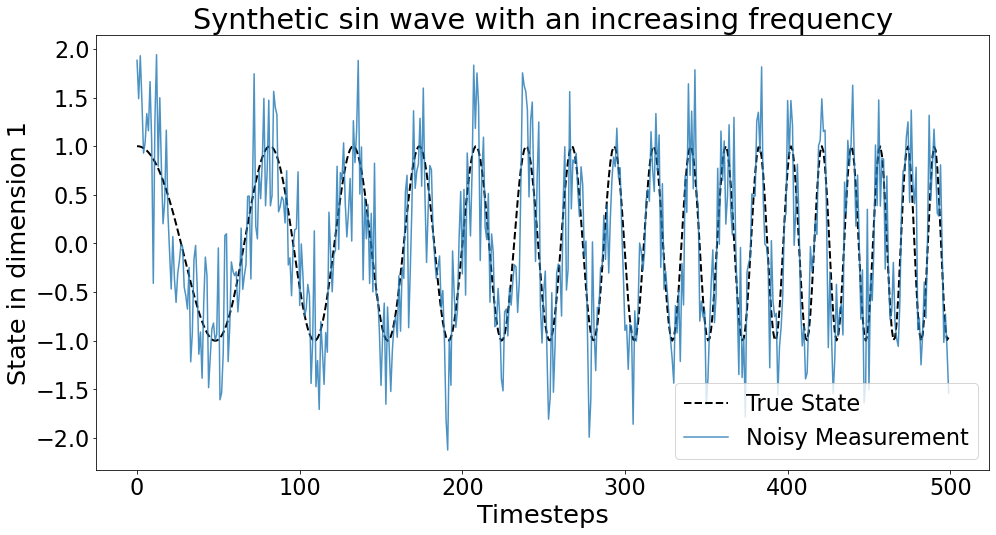

In [9]:
#Generate sin wave data with an increasing frequency from theta start to theta end

#Data Parameters
num_data = 500 -1 #how many data points to generate (+1)
num_for_spin_up = 100 #how many data points to use in the spin up phase
theta_start = np.pi/64 # starting system dynamics rotation at each step
theta_end = np.pi/8 #ending system dynamics rotation at each step
obs_cov_const = 0.5**2 # the measurement noise covariance (independent for each state dimension)

#Generate synthetic data
thetas = np.linspace(theta_start,theta_end,num_data)
true_data = ssf.generate_data(thetas).squeeze().T
noise = np.random.multivariate_normal([0]*2,obs_cov_const*np.identity(2),num_data+1)
data = true_data + noise.T

#plot the true data and noisy measurements, in their first dimension
plt.plot(true_data[0], label ='True State',alpha = 1, linewidth='2', ls='--',color='black')
plt.plot(data[0],alpha=0.8,color='tab:blue', label=f'Noisy Measurement')
#add plot details
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()
plt.title('Synthetic sin wave with an increasing frequency')
plt.savefig('assets/synthetic_data.png',bbox_inches='tight')

### Fit the DMDEnKF to the synthetic data

In [10]:
#Set the relevant parameters for the DMDEnKF
system_cov_const = (obs_cov_const/10)**2 #The system dynamics state covariance (independent for each dimension)
eig_cov_const = 0.01**2 #The system dynamics eigenvalue covariance (independent for each state dimension)
ensemble_size = 100 # The number of ensemble members to use in the DMDEnKF filtering step

#Fit a DMD model to the spin up data
f = TDMD()
f.fit(data[:,:num_for_spin_up],r=2)

#Set variables required for the DMDEnKF
x_len = f.data.shape[0]
e_len = f.E.shape[0]
observation_operator = np.hstack((np.identity(x_len),np.zeros((x_len,e_len))))
system_cov = np.diag([system_cov_const]*x_len + [eig_cov_const]*e_len)
observation_cov = obs_cov_const * np.identity(x_len)
P0 = np.real(np.cov(f.Y-(f.DMD_modes@np.diag(f.E)@np.linalg.pinv(f.DMD_modes)@f.X)))
P0 = np.block([[P0,np.zeros([x_len,e_len])],[np.zeros([e_len,x_len]),np.diag([eig_cov_const]*e_len)]])
Y = data[:,num_for_spin_up:]

#Fit the DMDEnKF to the rest of the data
dmdenkf = DMDEnKF(observation_operator=observation_operator, system_cov=system_cov,
                      observation_cov=observation_cov,P0=P0,DMD=f,ensemble_size=ensemble_size,Y=None)
dmdenkf.fit(Y=Y)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

### Plot the DMD reconstruction, and DMDEnKF tracking of the data

/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


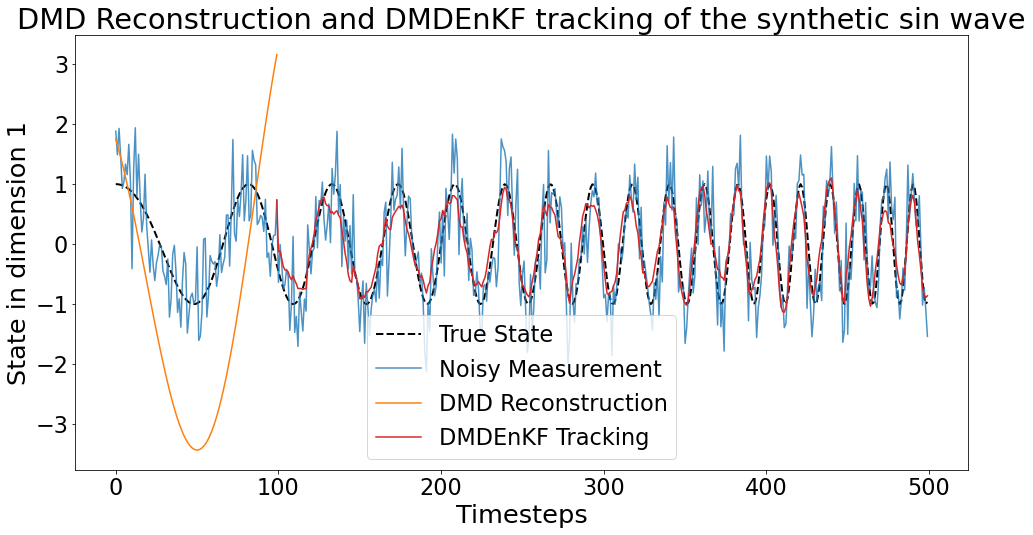

In [11]:
#plot the true data, noisy measurements, DMD reconstruction and DMDEnKF tracking all in their first dimension
plt.plot(true_data[0], label ='True State',alpha = 1, linewidth='2', ls='--',color='black')
plt.plot(data[0],alpha=0.8,color='tab:blue', label=f'Noisy Measurement')
plt.plot(f.reconstruct()[0],color='tab:orange',label='DMD Reconstruction')
plt.plot(range(num_data+1)[-len(dmdenkf.X):],np.array(dmdenkf.X)[:,:x_len].T[0],color='tab:red',label='DMDEnKF Tracking')
#add plot details
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()
plt.title('DMD Reconstruction and DMDEnKF tracking of the synthetic sin wave')
plt.savefig('assets/DMD_reconstruction_DMDEnKF_tracking.png',bbox_inches='tight')

### Plot the n step ahead DMDEnKF Forecast at each timestep

/home/falconical/anaconda3/envs/DMD/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


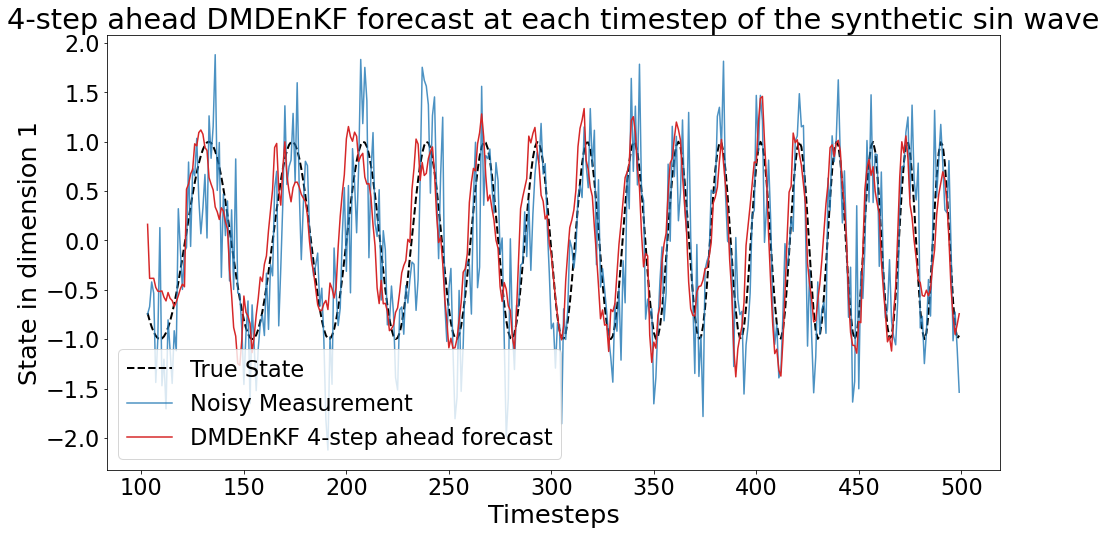

In [12]:
#forecasting parameters
n_steps_ahead = 4 #Number of steps ahead to forecast for each timestep

#create a forecast from the dmdenkfs ensemble
dmdenkf_forecast = dmdenkf.fast_predict_from_ensemble(n_steps_ahead)
timestep_to_plot = (num_data - num_for_spin_up - n_steps_ahead) + 2

#plot the true data, noisy measurements, DMD reconstruction and DMDEnKF tracking all in their first dimension
plt.plot(range(num_data+1)[-timestep_to_plot:],true_data[0][-timestep_to_plot:], label ='True State',alpha = 1, linewidth='2', ls='--',color='black')
plt.plot(range(num_data+1)[-timestep_to_plot:],data[0][-timestep_to_plot:],alpha=0.8,color='tab:blue', label=f'Noisy Measurement')
plt.plot(range(num_data+1)[-timestep_to_plot:],dmdenkf_forecast[:,:x_len].T[0][:-n_steps_ahead],color='tab:red',label=f'DMDEnKF {n_steps_ahead}-step ahead forecast')
#add plot details
plt.xlabel('Timesteps')
plt.ylabel('State in dimension 1')
plt.legend()
plt.title('4-step ahead DMDEnKF forecast at each timestep of the synthetic sin wave')
plt.savefig('assets/4-step_ahead_DMDEnKF_forecast.png',bbox_inches='tight')